In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ganga-river-data/GangaRiverData.csv
/kaggle/input/complete-shape-file/bounding area.dbf
/kaggle/input/complete-shape-file/bounding area.qmd
/kaggle/input/complete-shape-file/bounding area.shx
/kaggle/input/complete-shape-file/bounding area.cpg
/kaggle/input/complete-shape-file/bounding area.prj
/kaggle/input/complete-shape-file/bounding area.shp


In [5]:
!pip install geopandas requests rasterio

In [4]:
!pip install OWSLib Pillow requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 7.0 MB/s eta 0:00:00


In [3]:
import geopandas as gpd
from owslib.wms import WebMapService
import rasterio
from rasterio.io import MemoryFile
import os

# Step 1: Load the shapefile and get the bounding box
shapefile_path = '/kaggle/input/complete-shape-file/bounding area.shp'  # Path to your shapefile
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds  # (xmin, ymin, xmax, ymax)

# Step 2: Define the WMS service URL
wms_url = 'https://bhuvan-vec2.nrsc.gov.in/bhuvan/wms'
wms = WebMapService(wms_url, version='1.1.1')

# Step 3: List of WMS layers to download
layers = [
    
   'organization:wsh_mainriver',
    'organization:Ganga_CWC_Water_Quality_Stations',  # Add more layers as needed
    'organization:Ganga_118Towns_STP_Status',
    'organization:GangaRiver',
    'organization:cleanganga_Confluence_Points',
    'organization:cleanganga_STP_CETP',
    
    'organization:cleanganga_Sampling_Points',
    'organization:Cleanganga_MajorRiverswithName',
     'organization:cleanganga_Manual_Station_NRCD',
    'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_UK',
    'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_DL',
    'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_UP',
     'organization:cleanganga_Ghats_Crematoria_UK',
    'organization:cleanganga_Ghats_Crematoria_UP',
   
    'organization:cleanganga_Industry_n',
    'organization:cleanganga_RTQMS',

]

# Step 4: Loop through each layer and download it
output_dir = 'downloaded_layers_usgs'  # Directory to save the files
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

for layer_name in layers:
    # Request the WMS image using the bounding box
    wms_request = wms.getmap(
        layers=[layer_name],
        srs='EPSG:4326',
        bbox=bbox,
        size=(1024, 1024),  # Adjust size as needed
        format='image/tiff',
        transparent=True
      
    )

    # Step 5: Save the image as a TIFF file
    output_file = os.path.join(output_dir, f'{layer_name.split(":")[-1]}.tif')

    with MemoryFile(wms_request.read()) as memfile:
        with memfile.open() as dataset:
            # Save the image to a file
            with rasterio.open(output_file, 'w', **dataset.meta) as dst:
                dst.write(dataset.read())

    print(f"Downloaded {layer_name} and saved to {output_file}")

print("All layers downloaded successfully!")

ModuleNotFoundError: No module named 'owslib'

In [18]:
import requests
from PIL import Image
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.crs import CRS
import numpy as np
from io import BytesIO

# Define function to fetch WMS image
def fetch_wms_image(wms_url, params):
    response = requests.get(wms_url, params=params)
    if response.status_code == 200:
        print(response.content)
        return Image.open(BytesIO(response.content))
    else:
        raise Exception(f"Failed to fetch WMS image: {response.status_code}")

# Define function to crop image to shapefile bounds
def crop_image_to_shapefile(image, shapefile_path, output_path):
    # Load the shapefile with geopandas
    shapefile = gpd.read_file(shapefile_path)
    
    # Get the bounding box of the shapefile (minx, miny, maxx, maxy)
    bbox = shapefile.bounds.iloc[0]
    
    # WMS uses coordinates in (minx, miny, maxx, maxy) format
    left, bottom, right, top = bbox
    
    # Crop the image using the bounding box (note: WMS image may not have a matching CRS)
    cropped_image = image.crop((left, bottom, right, top))
    
    # Save the cropped image as a GeoTIFF
    save_as_geotiff(cropped_image, shapefile.crs, output_path, bbox)

# Define function to save the image as GeoTIFF
def save_as_geotiff(image, crs, output_path, bbox):
    # Convert the image to an array
    image_array = np.array(image)
    
    # Calculate the affine transform for the image (simple, assuming no rotation or skew)
    # This assumes a simple transformation from the bounding box coordinates to image pixels
    transform = from_origin(bbox[0], bbox[3], (bbox[2] - bbox[0]) / image.width, (bbox[3] - bbox[1]) / image.height)
    
    # Create the rasterio profile
    profile = {
        'driver': 'GTiff',
        'count': 3,  # RGB image
        'dtype': 'uint8',
        'crs': crs,  # Using CRS from shapefile
        'transform': transform,
        'width': image.width,
        'height': image.height,
        'nodata': 0,
    }
    
    # Write the GeoTIFF file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(image_array.transpose(2, 0, 1))  # Write the 3-band image (RGB)
shapefile_path = '/kaggle/input/caho-dataset/cat.shp'  # Replace with the correct shapefile path

shapefile = gpd.read_file(shapefile_path)
    
    # Get the bounding box of the shapefile (minx, miny, maxx, maxy)
bbox = shapefile.bounds.iloc[0]
# Example usage
wms_url = "https://basemap.nationalmap.gov:443/arcgis/services/USGSImageryOnly/MapServer/WMSServer?"  # Replace with the actual WMS URL
params = {
    'service': 'WMS',
    'version': '1.3.0',
    'request': 'GetMap',
    'layers': '0',  # Example: Replace with your layer number or name
   
    'bbox':bbox,
    'format': 'image/png',
  
    'height': 1256,  # Adjust height and width as needed
    'width': 1256,
    'srs': 'EPSG:4326'  # The spatial reference system
}

# Fetch WMS image
image = fetch_wms_image(wms_url, params)

# Path to your shapefile

# Output path for the cropped GeoTIFF
output_path = 'output_cropped_image.tif'  # Replace with desired output path

# Crop the image to the shapefile and save it as GeoTIFF
crop_image_to_shapefile(image, shapefile_path, output_path)


b'<?xml version="1.0" encoding="UTF-8" standalone="no" ?>\n<!DOCTYPE ServiceExceptionReport SYSTEM "http://schemas.opengis.net/wms/1.1.1/exception_1_1_1.dtd">\n<ServiceExceptionReport version="1.1.1">\n  <ServiceException code="InvalidFormat">\nCan\'t parse XML request.\n  </ServiceException>\n</ServiceExceptionReport>\n'


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7a32967c2a20>

In [10]:
!zip -r downloaded_layers_ganga.zip /kaggle/working/downloaded_layers_ganga


  adding: kaggle/working/downloaded_layers_ganga/ (stored 0%)
  adding: kaggle/working/downloaded_layers_ganga/GangaRiver.tif (deflated 99%)
  adding: kaggle/working/downloaded_layers_ganga/cleanganga_Confluence_Points.tif (deflated 100%)
  adding: kaggle/working/downloaded_layers_ganga/cleanganga_Ghats_Crematoria_UK.tif (deflated 100%)
  adding: kaggle/working/downloaded_layers_ganga/SISDP_P2_LULC_10K_2016_2019_UK.tif (deflated 74%)
  adding: kaggle/working/downloaded_layers_ganga/cleanganga_Sampling_Points.tif (deflated 100%)
  adding: kaggle/working/downloaded_layers_ganga/Cleanganga_MajorRiverswithName.tif (deflated 97%)
  adding: kaggle/working/downloaded_layers_ganga/cleanganga_Industry_n.tif (deflated 100%)
  adding: kaggle/working/downloaded_layers_ganga/wsh_mainriver.tif (deflated 99%)
  adding: kaggle/working/downloaded_layers_ganga/Ganga_118Towns_STP_Status.tif (deflated 100%)
  adding: kaggle/working/downloaded_layers_ganga/cleanganga_Manual_Station_NRCD.tif (deflated 100%)

In [6]:
import geopandas as gpd
from owslib.wms import WebMapService
import rasterio
from rasterio.io import MemoryFile
import os

# Step 1: Load the shapefile and get the bounding box
shapefile_path = '/kaggle/input/complete-shape-file/bounding area.shp'  # Path to your shapefile
gdf = gpd.read_file(shapefile_path)
bbox = gdf.total_bounds  # (xmin, ymin, xmax, ymax)

# Step 2: Define the WMS service URL
wms_url = 'https://bhuvan-vec2.nrsc.gov.in/bhuvan/wms'
wms = WebMapService(wms_url, version='1.1.1')

# Step 3: List of WMS layers to download
layers = [
    
  
    'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_UP',
     'organization:cleanganga_Ghats_Crematoria_UK',
    'organization:cleanganga_Ghats_Crematoria_UP',
   
    'organization:cleanganga_Industry_n',
    'organization:cleanganga_RTQMS',

]

# Step 4: Loop through each layer and download it
output_dir = 'downloaded_layers_ganga'  # Directory to save the files
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

for layer_name in layers:
    # Request the WMS image using the bounding box
    wms_request = wms.getmap(
        layers=[layer_name],
        srs='EPSG:4326',
        bbox=bbox,
        size=(1024, 1024),  # Adjust size as needed
        format='image/tiff',
        transparent=True
      
    )

    # Step 5: Save the image as a TIFF file
    output_file = os.path.join(output_dir, f'{layer_name.split(":")[-1]}.tif')

    with MemoryFile(wms_request.read()) as memfile:
        with memfile.open() as dataset:
            # Save the image to a file
            with rasterio.open(output_file, 'w', **dataset.meta) as dst:
                dst.write(dataset.read())

    print(f"Downloaded {layer_name} and saved to {output_file}")

print("All layers downloaded successfully!")


/opt/conda/lib/python3.10/site-packages/owslib/map/wms111.py:121: UserWarning: Content metadata for layer "disaster:AM_LS" already exists. Using child layer
  warnings.warn('Content metadata for layer "%s" already exists. Using child layer' % cm.id)


ReadTimeout: HTTPSConnectionPool(host='bhuvan-vec2.nrsc.gov.in', port=443): Read timed out. (read timeout=30)

In [ ]:
# 'organization:wsh_mainriver',
#     'organization:Ganga_CWC_Water_Quality_Stations',  # Add more layers as needed
#     'organization:Ganga_118Towns_STP_Status',
#     'organization:GangaRiver',
#     'organization:cleanganga_Confluence_Points',
#     'organization:cleanganga_STP_CETP',
    
#     'organization:cleanganga_Sampling_Points',
#     'organization:Cleanganga_MajorRiverswithName',
#      'organization:cleanganga_Manual_Station_NRCD',
#     'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_UK',
#     'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_DL',
#     'sisdp_phase2:SISDP_P2_LULC_10K_2016_2019_UP',
#      'organization:cleanganga_Ghats_Crematoria_UK',
#     'organization:cleanganga_Ghats_Crematoria_UP',

In [ ]:
!curl "ttps://rtwqmsdb1.cpcb.gov.in/data/internet/stations/stations.json

In [ ]:
pd.read_csv(/kaggle/input/ganga-river-data/GangaRiverData.csv)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import gradio as gr

# Load your data into pandas DataFrame
data =pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')

# Remove Time column for model training
data.drop(columns=['Time'], inplace=True)

# Preprocessing: MinMax scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Preparing the input data for all parameters
X = []
y = []
window_size = 3  # Define the window size for sequence prediction

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])  # Predicting all columns (parameters)

X, y = np.array(X), np.array(y)

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=X.shape[2]))  # Output layer size equal to the number of features

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32)

# Predictions
predicted_values = model.predict(X)
predicted_values_rescaled = scaler.inverse_transform(predicted_values)

# Actual vs Predicted Plot (for Temperature as example)
plt.plot(data['Temp'].values[window_size:], color='blue', label='Actual Temp')
plt.plot(predicted_values_rescaled[:, 0], color='red', label='Predicted Temp')  # Plot only Temp predictions
plt.title('Actual vs Predicted Temp')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Gradio Deployment
def predict(parameter):
    param_index = list(data.columns).index(parameter)
    predicted_param = predicted_values_rescaled[:, param_index]
    return predicted_param.tolist()

iface = gr.Interface(
    fn=predict,
    inputs=gr.inputs.Dropdown(choices=['Temp', 'pH', 'ORP', 'EC', 'RES', 'TDS', 'Salinity', 'Pressure'], label="Parameter to Predict"),
    outputs="text",
    title="Parameter Prediction",
    description="Predict any water quality parameter based on historical data."
)

iface.launch()


In [7]:
!pip install gradio 

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 69.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 98.8 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.8.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have goog

Epoch 1/20


/tmp/ipykernel_36/1913617022.py:13: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0942
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0239
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0199
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0172
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0161
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0151
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137
Epoch 8/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0138
Epoch 9/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132
Epoch 10/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126
Epoch 11/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118
Epoch 12/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0115
Epoch 13/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113
Epoch 14/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108
Epoch 15/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097
Epoch 16/20
71/71 ━━━━━━━━━━━━

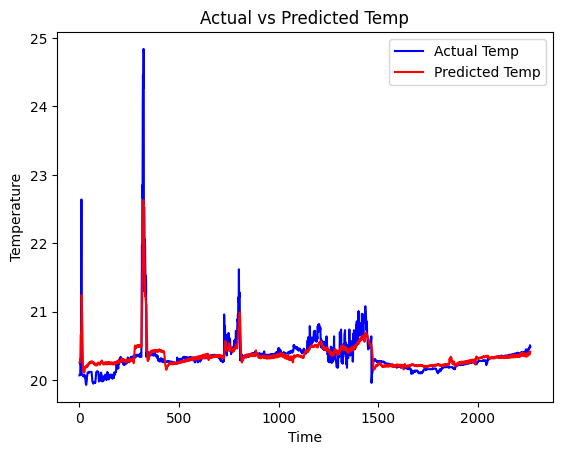

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import gradio as gr

# Load your data into pandas DataFrame
data =pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')

# Combine Date and Time columns into a datetime feature
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Feature Engineering: Extract useful time components (e.g., Hour, Minute, Second)
data['Hour'] = data['DateTime'].dt.hour
data['Minute'] = data['DateTime'].dt.minute
data['Second'] = data['DateTime'].dt.second

# Drop original Date, Time, and DateTime columns
data.drop(columns=['Date', 'Time', 'DateTime'], inplace=True)

# Preprocessing: MinMax scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Preparing the input data for all parameters
X = []
y = []
window_size = 60  # Define the window size for sequence prediction

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])  # Predicting all columns (parameters)

X, y = np.array(X), np.array(y)

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=X.shape[2]))  # Output layer size equal to the number of features

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=32)
model.save('Lstm_Ganga.h5')
# Predictions
predicted_values = model.predict(X)
predicted_values_rescaled = scaler.inverse_transform(predicted_values)

# Actual vs Predicted Plot (for Temperature as example)
plt.plot(data['Temp'].values[window_size:], color='blue', label='Actual Temp')
plt.plot(predicted_values_rescaled[:, 0], color='red', label='Predicted Temp')  # Plot only Temp predictions
plt.title('Actual vs Predicted Temp')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()
model.save("lstm_water_quality_model.h5")
# Gradio Deployment



In [ ]:
def predict(parameter):
    param_index = list(data.columns).index(parameter)
    predicted_param = predicted_values_rescaled[:, param_index]
    return predicted_param.tolist()

iface = gr.Interface(
    fn=predict,
    inputs=gr.inputs.Dropdown(choices=['Temp', 'pH', 'ORP', 'EC', 'RES', 'TDS', 'Salinity', 'Pressure'], label="Parameter to Predict"),
    outputs="text",
    title="Water Quality Parameter Prediction",
    description="Predict any water quality parameter based on historical data."
)

iface.launch(share=True)

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import gradio as gr

# Load your data into pandas DataFrame
data = pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')

# Combine Date and Time columns into a datetime feature
data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Feature Engineering: Extract useful time components (e.g., Hour, Minute, Second)


# Drop original Date, Time, and DateTime columns
data.drop(columns=['Date', 'Time',], inplace=True)

# Preprocessing: MinMax scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.iloc[:,1:])

# Preparing the input data for all parameters
X = []
y = []
window_size = 600  # Define the window size for sequence prediction

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])  # Predicting all columns (parameters)

X, y = np.array(X), np.array(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=X_train.shape[2]))  # Output layer size equal to the number of features

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)  # Added validation split

# Predictions
predicted_values = model.predict(X_test)
predicted_values_rescaled = scaler.inverse_transform(predicted_values)
y_test_rescaled = scaler.inverse_transform(y_test)

# Compute metrics
mse = mean_squared_error(y_test_rescaled, predicted_values_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Plot Actual vs Predicted (for Temperature as an example)
plt.figure(figsize=(14, 7))
plt.plot(X_test['Temp'].values[window_size:], color='blue', label='Actual Temp')
plt.plot(predicted_values_rescaled[:, 0], color='red', label='Predicted Temp')  # Plot only Temp predictions
plt.title('Actual vs Predicted Temp')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

model.save("lstm_water_quality_model.h5")

# Gradio Deployment
# You can add Gradio code here to deploy the model if needed


/tmp/ipykernel_36/2524024487.py:15: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['DateTime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)

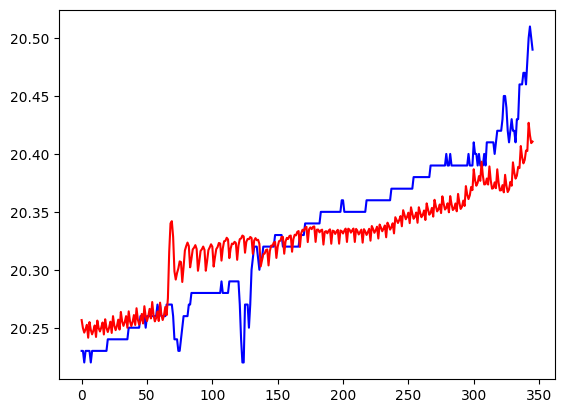

In [14]:
plt.plot(y_test_rescaled[:, 0], color='blue', label='Actual Temp')
plt.plot(predicted_values_rescaled[:, 0], color='red', label='Predicted Temp')

In [ ]:
def predict(parameter):
    param_index = list(data.columns).index(parameter)
    predicted_param = predicted_values_rescaled[:, param_index]
    return predicted_param.tolist()


iface = gr.Interface(
    fn=predict,
    inputs=gr.Dropdown(choices=['Temp', 'pH', 'ORP', 'EC', 'RES', 'TDS', 'Salinity', 'Pressure'], label="Parameter to Predict"),
    outputs=gr.Textbox(),
    title="Water Quality Parameter Prediction",
    description="Predict water quality parameters using an LSTM model."
)

# Launch app
iface.launch(share=True)

In [ ]:
def predict(parameter):
    # Predict the last sequence
    predicted_values = model.predict(X[-1].reshape(1, X.shape[1], X.shape[2]))

    # Rescale the predicted values back to the original scale
    predicted_values_rescaled = scaler.inverse_transform(predicted_values)
    
    # Select the predicted parameter
    param_index = data.columns.get_loc(parameter)
    predicted_param = predicted_values_rescaled[0][param_index]
    
    # Plot actual vs predicted values
    plt.figure(figsize=(10,6))
    actual_values = data[parameter][-len(X):].values
    predicted_values = scaler.inverse_transform(model.predict(X))[:, param_index]

    plt.plot(actual_values, label='Actual')
    plt.plot(predicted_values, label='Predicted', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel(parameter)
    plt.title(f'Actual vs Predicted {parameter}')
    plt.legend()

    # Save the plot to a buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    
    # Convert the buffer to a base64 image
    image_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')
    buf.close()
    
    return f'<img src="data:image/png;base64,{image_base64}" />'

# Gradio Interface
iface = gr.Interface(
    fn=predict,
    inputs=gr.Dropdown(choices=['Temp', 'pH', 'ORP', 'EC', 'RES', 'TDS', 'Salinity', 'Pressure'], label="Parameter to Predict"),
    outputs=gr.HTML(),
    title="Water Quality Parameter Prediction",
    description="Predict and visualize any water quality parameter using LSTM model."
)

# Launch Gradio app
iface.launch()

In [18]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'lag-llama'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 334 (delta 116), reused 113 (delta 86), pack-reused 162 (from 1)
Receiving objects: 100% (334/334), 236.58 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [1]:
%cd /kaggle/working/lag-llama

/kaggle/working/lag-llama


In [2]:
!pip install -r requirements.txt --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.2 requires cubinlinker, which is not installed.
cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.2 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.2 requires cupy-cuda11x>=12.0.0, which is not installed.
beatrix-jupyterlab 2024.66.154055 requires jupyterlab~=3.6.0, but you have jupyterlab 4.2.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.1.4 which is incompatible.
cudf 24.8.2 requires cuda-python

In [38]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /kaggle/working/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


lag-llama.ckpt: 100%|██████████████████████| 29.5M/29.5M [00:00<00:00, 53.3MB/s]
Download complete. Moving file to /kaggle/working/lag-llama.ckpt
/kaggle/working/lag-llama.ckpt


In [3]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator
import pandas as pd 

/opt/conda/lib/python3.10/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = to_offset(freq)


In [4]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=60, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("/kaggle/working/lag-llama.ckpt", map_location=device) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="/kaggle/working/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length
       
        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
     
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

In [5]:
# df=pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')
df =pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')

# Combine Date and Time columns into a datetime feature
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


# Feature Engineering: Extract useful time components (e.g., Hour, Minute, Second)


# Drop original Date, Time, and DateTime columns
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()
df.set_index('DateTime', inplace=True)

display(df.head())
for col in df.columns[:]:
    
    # Check if column is not of string type
    if df[col].dtype != 'object'and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')
# Corrected Series display


display(df.head())

/tmp/ipykernel_36/647993809.py:5: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity,DateTime
0,20.67,8.40,88.6,470,2128,306,0.23,14.568,101.5,36.7,2020-02-17 17:04:52
1,20.67,8.40,88.5,470,2128,305,0.23,14.569,101.4,42.4,2020-02-17 17:05:02
2,20.67,8.40,88.2,470,2128,305,0.23,14.569,101.5,38.2,2020-02-17 17:05:12
3,20.67,8.40,87.9,470,2128,305,0.23,14.567,101.7,38.0,2020-02-17 17:05:22
4,20.68,8.41,87.8,469,2132,305,0.23,14.566,101.7,46.8,2020-02-17 17:05:32


In [6]:

# display(df.head())


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.6,470,2128,306,0.23,14.568,101.5,36.7
2020-02-17 17:05:02,20.67,8.40,88.5,470,2128,305,0.23,14.569,101.4,42.4
2020-02-17 17:05:12,20.67,8.40,88.2,470,2128,305,0.23,14.569,101.5,38.2
2020-02-17 17:05:22,20.67,8.40,87.9,470,2128,305,0.23,14.567,101.7,38.0
2020-02-17 17:05:32,20.68,8.41,87.8,469,2132,305,0.23,14.566,101.7,46.8


/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:02,20.67,8.40,88.500000,470.0,2128.0,305.0,0.23,14.569,101.400002,42.400002
2020-02-17 17:05:12,20.67,8.40,88.199997,470.0,2128.0,305.0,0.23,14.569,101.500000,38.200001
2020-02-17 17:05:22,20.67,8.40,87.900002,470.0,2128.0,305.0,0.23,14.567,101.699997,38.000000
2020-02-17 17:05:32,20.68,8.41,87.800003,469.0,2132.0,305.0,0.23,14.566,101.699997,46.799999


In [14]:
# Corrected Series display
display(pd.Series([1]*df.shape[0]))

# Correctly assign a column with repeated values
df['item_id'] = [1]*df.shape[0]

# Display the first few rows of the DataFrame
display(df.head())



0       1
1       1
2       1
3       1
4       1
       ..
2321    1
2322    1
2323    1
2324    1
2325    1
Length: 2326, dtype: int64

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity,item_id
DateTime,,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001,1
2020-02-17 17:05:02,20.67,8.40,88.500000,470.0,2128.0,305.0,0.23,14.569,101.400002,42.400002,1
2020-02-17 17:05:12,20.67,8.40,88.199997,470.0,2128.0,305.0,0.23,14.569,101.500000,38.200001,1
2020-02-17 17:05:22,20.67,8.40,87.900002,470.0,2128.0,305.0,0.23,14.567,101.699997,38.000000,1
2020-02-17 17:05:32,20.68,8.41,87.800003,469.0,2132.0,305.0,0.23,14.566,101.699997,46.799999,1


In [7]:
  # Define your prediction length. We use 24 here since the data is of hourly frequency
display(df.head())
if not df.index.is_monotonic_increasing:
    df.sort_index(inplace=True)  # Sort the index if not already sorted

# Try to infer the frequency, or set it manually if needed
df = df.asfreq('T' )  # Assuming minute-level frequency; replace 'T' with appropriate frequency

# Display the first few rows to check
df.head()
# df.index.name = None
df.index = pd.DatetimeIndex(df.index, freq='T')
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
display(df.index)

display(df.head())

# device = torch.device("cuda:0")

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:02,20.67,8.40,88.500000,470.0,2128.0,305.0,0.23,14.569,101.400002,42.400002
2020-02-17 17:05:12,20.67,8.40,88.199997,470.0,2128.0,305.0,0.23,14.569,101.500000,38.200001
2020-02-17 17:05:22,20.67,8.40,87.900002,470.0,2128.0,305.0,0.23,14.567,101.699997,38.000000
2020-02-17 17:05:32,20.68,8.41,87.800003,469.0,2132.0,305.0,0.23,14.566,101.699997,46.799999


/tmp/ipykernel_36/2012238133.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T' )  # Assuming minute-level frequency; replace 'T' with appropriate frequency
/tmp/ipykernel_36/2012238133.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.index = pd.DatetimeIndex(df.index, freq='T')


DatetimeIndex(['2020-02-17 17:04:52', '2020-02-17 17:05:52',
               '2020-02-17 17:06:52', '2020-02-17 17:07:52',
               '2020-02-17 17:08:52', '2020-02-17 17:09:52',
               '2020-02-17 17:10:52', '2020-02-17 17:11:52',
               '2020-02-17 17:12:52', '2020-02-17 17:13:52',
               ...
               '2020-02-20 09:36:52', '2020-02-20 09:37:52',
               '2020-02-20 09:38:52', '2020-02-20 09:39:52',
               '2020-02-20 09:40:52', '2020-02-20 09:41:52',
               '2020-02-20 09:42:52', '2020-02-20 09:43:52',
               '2020-02-20 09:44:52', '2020-02-20 09:45:52'],
              dtype='datetime64[ns]', name='DateTime', length=3882, freq='min')

/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: DatetimeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.670000,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:52,20.680000,8.41,87.500000,469.0,2132.0,305.0,0.23,14.570,101.800003,45.500000
2020-02-17 17:06:52,20.170000,8.98,69.699997,437.0,2288.0,284.0,0.21,14.568,111.699997,13.900000
2020-02-17 17:07:52,20.120001,9.03,65.099998,431.0,2320.0,280.0,0.21,14.572,114.300003,14.800000
2020-02-17 17:08:52,20.100000,9.04,68.699997,428.0,2336.0,278.0,0.21,14.565,115.099998,14.800000


In [11]:
df.dropna(inplace=True)
dataset=PandasDataset(dict(df))
backtest_dataset = dataset
prediction_length = 64


In [194]:
df.index[-1]

Timestamp('2020-02-20 09:45:52')

In [14]:
import pandas as pd
from gluonts.dataset.pandas import PandasDataset

url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
# Set numerical columns as float32
for col in df.columns:
    # Check if column is not of string type
    if df[col].dtype != 'object' and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')

# Create the Pandas
dataset = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id")

backtest_dataset = dataset
prediction_length = 24  # Define your prediction length. We use 24 here since the data is of hourly frequency
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment
forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples)

/tmp/ipykernel_36/3917178031.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/lag-llama.ckpt", map_location=device) # Uses GPU since in

ValueError: invalid frequency | `freq_str=Q` -> `offset_name=QE`

In [13]:
# prediction_length=60
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

forecasts, tss = get_lag_llama_predictions(backtest_dataset,24,device, 100)


/tmp/ipykernel_36/3917178031.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("/kaggle/working/lag-llama.ckpt", map_location=device) # Uses GPU since in

ValueError: invalid frequency | `freq_str=Q` -> `offset_name=QE`

In [50]:
forecasts[0].samples.shape


NameError: name 'forecasts' is not defined

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="XcMFmPvAHtkpaoKxd3m1")
project = rf.workspace("paridhi-modi-zoogr").project("arrow-detection-puzso")
version = project.version(6)
dataset = version.download("yolov9")

#Testing Gluon ts model 


In [1]:
!pip install "gluonts[torch]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 871.2 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.2 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.4.0
    Uninstalling pytorch-lightning-2.4.0:
      Successfully uninstalled pytorch-lightning-2.4.0


In [20]:
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator
# ------------------------------------Loading the file ---------------------------
# Load data from a CSV file into a PandasDataset
df =pd.read_csv('/kaggle/input/ganga-river-data/GangaRiverData.csv')

# Combine Date and Time columns into a datetime feature
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


# Feature Engineering: Extract useful time components (e.g., Hour, Minute, Second)


# Drop original Date, Time, and DateTime columns
df.drop(columns=['Date', 'Time'], inplace=True)
df.head()
df.set_index('DateTime', inplace=True)

display(df.head())
for col in df.columns[:]:
    
    # Check if column is not of string type
    if df[col].dtype != 'object'and pd.api.types.is_string_dtype(df[col]) == False:
        df[col] = df[col].astype('float32')
# Corrected Series display


display(df.head())
if not df.index.is_monotonic_increasing:
    df.sort_index(inplace=True)  # Sort the index if not already sorted

# Try to infer the frequency, or set it manually if needed
df = df.asfreq('T' )  # Assuming minute-level frequency; replace 'T' with appropriate frequency

# Display the first few rows to check
display(df.head())
# df.index.name = None
df.index = pd.DatetimeIndex(df.index, freq='T')
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
display(df.index)

display(df.head())
#-------------------------------------------------------------------------
dataset = PandasDataset(dict(df))

# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-60)
test_data = test_gen.generate_instances(prediction_length=60, windows=1)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=60, freq="T", trainer_kwargs={"max_epochs": 5}
).train(training_data)

forecasts = list(model.predict(test_data.input))

# Plot predictions


/tmp/ipykernel_36/1823824472.py:12: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.6,470,2128,306,0.23,14.568,101.5,36.7
2020-02-17 17:05:02,20.67,8.40,88.5,470,2128,305,0.23,14.569,101.4,42.4
2020-02-17 17:05:12,20.67,8.40,88.2,470,2128,305,0.23,14.569,101.5,38.2
2020-02-17 17:05:22,20.67,8.40,87.9,470,2128,305,0.23,14.567,101.7,38.0
2020-02-17 17:05:32,20.68,8.41,87.8,469,2132,305,0.23,14.566,101.7,46.8


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.67,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:02,20.67,8.40,88.500000,470.0,2128.0,305.0,0.23,14.569,101.400002,42.400002
2020-02-17 17:05:12,20.67,8.40,88.199997,470.0,2128.0,305.0,0.23,14.569,101.500000,38.200001
2020-02-17 17:05:22,20.67,8.40,87.900002,470.0,2128.0,305.0,0.23,14.567,101.699997,38.000000
2020-02-17 17:05:32,20.68,8.41,87.800003,469.0,2132.0,305.0,0.23,14.566,101.699997,46.799999


/tmp/ipykernel_36/1823824472.py:37: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.asfreq('T' )  # Assuming minute-level frequency; replace 'T' with appropriate frequency


,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.670000,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:52,20.680000,8.41,87.500000,469.0,2132.0,305.0,0.23,14.570,101.800003,45.500000
2020-02-17 17:06:52,20.170000,8.98,69.699997,437.0,2288.0,284.0,0.21,14.568,111.699997,13.900000
2020-02-17 17:07:52,20.120001,9.03,65.099998,431.0,2320.0,280.0,0.21,14.572,114.300003,14.800000
2020-02-17 17:08:52,20.100000,9.04,68.699997,428.0,2336.0,278.0,0.21,14.565,115.099998,14.800000


/tmp/ipykernel_36/1823824472.py:42: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.index = pd.DatetimeIndex(df.index, freq='T')


DatetimeIndex(['2020-02-17 17:04:52', '2020-02-17 17:05:52',
               '2020-02-17 17:06:52', '2020-02-17 17:07:52',
               '2020-02-17 17:08:52', '2020-02-17 17:09:52',
               '2020-02-17 17:10:52', '2020-02-17 17:11:52',
               '2020-02-17 17:12:52', '2020-02-17 17:13:52',
               ...
               '2020-02-20 09:36:52', '2020-02-20 09:37:52',
               '2020-02-20 09:38:52', '2020-02-20 09:39:52',
               '2020-02-20 09:40:52', '2020-02-20 09:41:52',
               '2020-02-20 09:42:52', '2020-02-20 09:43:52',
               '2020-02-20 09:44:52', '2020-02-20 09:45:52'],
              dtype='datetime64[ns]', name='DateTime', length=3882, freq='min')

,Temp,pH,ORP,EC,RES,TDS,Salinity,Pressure,D.O.,Turbidity
DateTime,,,,,,,,,,
2020-02-17 17:04:52,20.670000,8.40,88.599998,470.0,2128.0,306.0,0.23,14.568,101.500000,36.700001
2020-02-17 17:05:52,20.680000,8.41,87.500000,469.0,2132.0,305.0,0.23,14.570,101.800003,45.500000
2020-02-17 17:06:52,20.170000,8.98,69.699997,437.0,2288.0,284.0,0.21,14.568,111.699997,13.900000
2020-02-17 17:07:52,20.120001,9.03,65.099998,431.0,2320.0,280.0,0.21,14.572,114.300003,14.800000
2020-02-17 17:08:52,20.100000,9.04,68.699997,428.0,2336.0,278.0,0.21,14.565,115.099998,14.800000


/opt/conda/lib/python3.10/site-packages/gluonts/time_feature/_base.py:249: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  offset = to_offset(freq_str)
/opt/conda/lib/python3.10/site-packages/gluonts/time_feature/lag.py:104: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  offset = to_offset(freq_str)
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step`

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 0.08731 (best 0.08731), saving model to '/kaggle/working/lightning_logs/version_10/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 0.06696 (best 0.06696), saving model to '/kaggle/working/lightning_logs/version_10/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' was not in top 1
INFO: Epoch 3, global step 200: 'train_loss' reached 0.04980 (best 0.04980), saving model to '/kaggle/working/lightning_logs/version_10/checkpoints/epoch=3-step=200.ckpt' as top 1
INFO: Epoch 4, global step 250: 'train_loss' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
/opt/conda/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute ar

In [ ]:
forecasts = list(model.predict(test_data.input))
print(forecasts)
# plt.plot(data=df.iloc[:,:2] )
for i,forecast in enumerate (forecasts):
    plt.plot(df.index[1000:],df.iloc[1000:,i])
    plt.xticks(ticks=df.index[1000:],labels=df.index[1000:],rotation=45)
    plt.show()
    forecast.plot()
    plt.title(forecast.item_id)
    plt.show()
#    plt.plot(forecast.samples)
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()


[gluonts.model.forecast.SampleForecast(info=None, item_id='Temp', samples=array([[-7.57910054e-11,  1.13768259e-10, -6.84970206e-11, ...,
        -1.68206310e-10, -1.29072697e-10,  1.12587266e-10],
       [-3.53610197e-11,  1.03593679e-11, -2.09689807e-10, ...,
        -2.17664817e-10, -2.60484234e-13, -5.05133088e-11],
       [ 1.47079876e-10, -3.86891647e-12,  6.77696718e-11, ...,
         2.30600695e-11,  2.73349884e-11, -4.48351382e-12],
       ...,
       [-2.27829575e-10, -2.36664906e-11,  3.50198447e-11, ...,
        -1.27300559e-10, -6.40751271e-11, -1.97336134e-10],
       [ 4.20991263e-11, -1.50154819e-10, -1.68735373e-10, ...,
         7.96842887e-12, -1.97978699e-11,  7.26306602e-12],
       [ 1.00459384e-10,  2.68900128e-11, -6.38498698e-11, ...,
         5.39682916e-11,  2.48689236e-10,  1.02910069e-09]], dtype=float32), start_date=Period('2020-02-20 08:46', 'min')), gluonts.model.forecast.SampleForecast(info=None, item_id='pH ', samples=array([[ 2.2978795e-10,  2.2187085

In [35]:
plt.xticks??

Signature: plt.xticks(ticks=None, labels=None, *, minor=False, **kwargs)
Source:   
def xticks(ticks=None, labels=None, *, minor=False, **kwargs):
    """
    Get or set the current tick locations and labels of the x-axis.

    Pass no arguments to return the current values without modifying them.

    Parameters
    ----------
    ticks : array-like, optional
        The list of xtick locations.  Passing an empty list removes all xticks.
    labels : array-like, optional
        The labels to place at the given *ticks* locations.  This argument can
        only be passed if *ticks* is passed as well.
    minor : bool, default: False
        If ``False``, get/set the major ticks/labels; if ``True``, the minor
        ticks/labels.
    **kwargs
        `.Text` properties can be used to control the appearance of the labels.

    Returns
    -------
    locs
        The list of xtick locations.
    labels
        The list of xlabel `.Text` objects.

    Notes
    -----
    Calling this fu

2d simulation using hec ras 


In [1]:
!pip install rasterio raspy

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for raspy: filename=raspy-0.5-py3-none-any.whl size=1045 sha256=385725a439dd304991daaea0ae1fb0c67bf1b799f8412c05d691ba65c36adae7
  Stored in directory: /root/.cache/pip/wheels/41/6f/ba/d4bfad7e0f769645a106c4237acbd0da48103f398e4bfabeb9
  Created wheel for RPi.GPIO: filename=RPi.GPIO-0.7.1-cp310-cp310-linux_x86_64.whl size=30488 sha256=8636681d0f53e04b8f433511baf7d103bfbed9c70f4e7cfa28fd5fe4d8e3a77a
  Stored in directory: /root/.cache/pip/wheels/01/87/cc/db7d6af3c88be9bf050abd43a7e63ae99c93a678fd9e00addd
Successfully built raspy RPi.GPIO


In [7]:
!pip install raspy-auto

INFO: pip is looking at multiple versions of raspy-auto to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install raspy-auto==1.0.0, raspy-auto==1.0.1, raspy-auto==1.0.2, raspy-auto==1.0.3, raspy-auto==1.1.0 and raspy-auto==1.1.1 because these package versions have conflicting dependencies.

The conflict is caused by:
    raspy-auto 1.1.1 depends on pywin32
    raspy-auto 1.1.0 depends on pywin32
    raspy-auto 1.0.3 depends on pywin32
    raspy-auto 1.0.2 depends on pywin32
    raspy-auto 1.0.1 depends on pywin32
    raspy-auto 1.0.0 depends on pywin32

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts


In [8]:
import geopandas as gpd
import numpy as np
import rasterio
import raspy

# Step 1: Load the River Network, DEM, and LULC Data
river_shapefile = "/kaggle/input/caho-cropped-region/cahor_river_cropped.shp"
lulc_file = "/kaggle/input/caho-pt2/NLCD_landcover_2021.tif"  # LULC data in raster format
dem_file = "/kaggle/input/dem-caho/07140101demg.tif"

# Load river network shapefile
river_network = gpd.read_file(river_shapefile)

# Load DEM and LULC raster data for additional spatial parameters
with rasterio.open(dem_file) as dem:
    dem_data = dem.read(1)  # Elevation values
    dem_crs = dem.crs  # Coordinate Reference System

with rasterio.open(lulc_file) as lulc:
    lulc_data = lulc.read(1)  # Land-use values
    lulc_crs = lulc.crs  # Coordinate Reference System

# Step 2: Define boundary conditions
# Identify inlet (topmost) and outlets based on river network properties
top_segment = river_network.loc[river_network['wasp_id'] == 61]  # Replace with valid column/ID
outlet_segments = river_network[river_network['type'] == 'outlet']  # Replace with valid column/condition

# Example discharge values
inlet_discharge = 5000  # Random inflow rate in m³/s
outlet_discharges = np.random.uniform(1000, 3000, len(outlet_segments))  # Randomized outlet discharges

# Step 3: Prepare HEC-RAS Project
project = raspy.Project("MississippiSimulation")
geometry = project.geometry()

# Add the DEM to geometry
geometry.add_dem(dem_file)

# Add river network shapefile
geometry.add_river_network(river_shapefile)

# Add LULC data as raster
geometry.add_land_cover(lulc_file)

# Set boundary conditions
geometry.add_boundary_condition(
    location="upstream",  # Adjust based on upstream segment name/ID
    boundary_type="flow",
    value=inlet_discharge
)

for idx, segment in outlet_segments.iterrows():
    geometry.add_boundary_condition(
        location=segment['name'],  # Use unique ID/name from the shapefile
        boundary_type="flow",
        value=outlet_discharges[idx]
    )

# Step 4: Run the Simulation
project.set_computation_parameters(
    computation_interval="1H",  # Hourly intervals
    simulation_duration="3D"    # 3-day simulation
)

# Execute the simulation
results = project.run()

# Step 5: Analyze Results
# Extract 2D output results
water_depth = results.get("water_depth")
pollutant_concentration = results.get("pollutant_concentration")

# Visualization using matplotlib
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, ax = plt.subplots(figsize=(10, 6))
show(water_depth, ax=ax, title="Water Depth Simulation Results")
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
show(pollutant_concentration, ax=ax, title="Pollutant Concentration Simulation Results")
plt.show()


ModuleNotFoundError: No module named 'raspy'

In [11]:
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd

# File paths
dem_file = "/kaggle/input/dem-caho/07140101demg.tif"
extent_tiff = "/kaggle/input/caho-cropped-region/caho_aerial.tif"

# Load the extent from the extent TIFF
with rasterio.open(extent_tiff) as extent:
    extent_bounds = extent.bounds

# Convert the bounds to a Shapely geometry
extent_geometry = [box(*extent_bounds)]  # Creates a Polygon from the bounding box

# Crop the DEM using the extent geometry
with rasterio.open(dem_file) as src:
    cropped_dem, cropped_transform = mask(
        src, extent_geometry, crop=True
    )

# Save the cropped DEM
cropped_dem_path = "/kaggle/working/cropped_dem.tif"
with rasterio.open(
    cropped_dem_path, 'w',
    driver='GTiff',
    height=cropped_dem.shape[1],
    width=cropped_dem.shape[2],
    count=1,
    dtype=cropped_dem.dtype,
    crs=src.crs,
    transform=cropped_transform
) as dest:
    dest.write(cropped_dem, 1)

print("Cropped DEM saved to:", cropped_dem_path)


ValueError: Input shapes do not overlap raster.

In [23]:
!pip install simpy



Final pollution concentration: 94.43754972406816


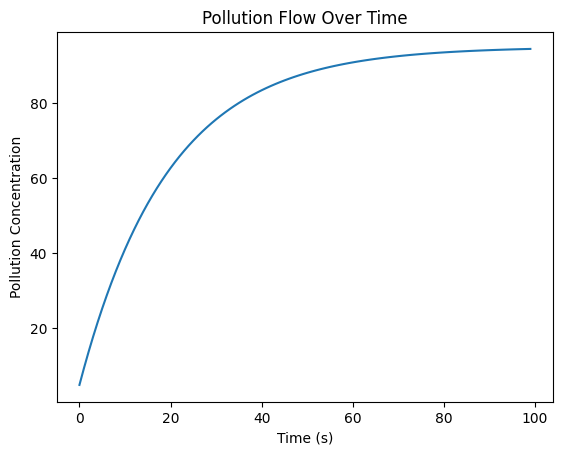

In [25]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

def pollution_flow(env, pollution_rate, flow_rate, location, pollution_history):
    while True:
        # Simulate pollution flow (concentration change based on flow)
        location["pollution"] += pollution_rate
        location["pollution"] *= flow_rate  # Decay factor based on flow
        
        # Record pollution concentration at each time step for visualization
        pollution_history.append(location["pollution"])
        
        # Wait until the next update
        yield env.timeout(1)  # Update every second

# Initialize environment and locations
env = simpy.Environment()
location = {"pollution": 0}  # Initial pollution concentration at location
pollution_history = []  # List to store pollution concentration over time

# Start simulation with a pollution source and flow conditions
env.process(pollution_flow(env, pollution_rate=5, flow_rate=0.95, location=location, pollution_history=pollution_history))

# Run the simulation
env.run(until=100)  # Run for 100 simulation steps

# Output the final pollution concentration
print(f"Final pollution concentration: {location['pollution']}")

# Plot the pollution concentration over time
plt.plot(pollution_history)
plt.title('Pollution Flow Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Pollution Concentration')
plt.show()


In [31]:
!pip install pyecohydro


ERROR: Could not find a version that satisfies the requirement pyecohydro (from versions: none)
ERROR: No matching distribution found for pyecohydro


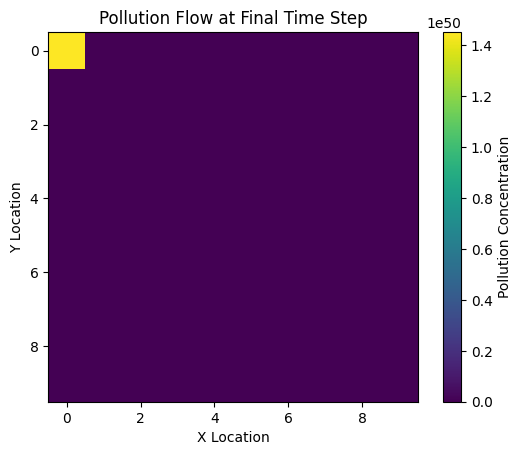

In [29]:
from pyecohydro import WaterQualityModel
import numpy as np
import matplotlib.pyplot as plt

# Initialize water quality model
model = WaterQualityModel()

# Create a 2D grid representing pollution concentrations
grid_size = (10, 10)
pollution_grid = np.zeros(grid_size)

# Set initial pollution rate (e.g., 5 units of pollution in the top-left corner)
pollution_grid[0, 0] = 5

# Run the model for several timesteps
time_steps = 100
for t in range(time_steps):
    # Update the pollution grid using some hydrodynamic transport model (here, for simplicity)
    # You can implement more complex diffusion and flow models
    pollution_grid = model.simulate(pollution_grid)

    # Plot the pollution grid at each time step
    plt.imshow(pollution_grid, cmap='viridis')
    plt.colorbar(label='Pollution Concentration')
    plt.title(f'Pollution Flow at Time Step {t}')
    plt.xlabel('X Location')
    plt.ylabel('Y Location')
    plt.show()


In [5]:
!pip install pyHMT2D


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.2 MB/s eta 0:00:00


In [1]:
from pyhms2d import RasSimulation
import numpy as np
import matplotlib.pyplot as plt

# Load the HEC-RAS model
hec_ras_file = "/kaggle/input/hec-ras/newww.prj"
sim = RasSimulation(hec_ras_file)

# Start the simulation
sim.start_simulation()

# Initialize pollutant concentration array (e.g., 2D grid matching geometry)
pollutant_grid = np.zeros((sim.grid_shape[0], sim.grid_shape[1]))  # Example: pollution starts at 0

# Define parameters
pollution_rate = 5.0  # Pollution input rate at source (arbitrary units)
decay_rate = 0.1      # Rate of pollutant decay (e.g., due to dispersion or biodegradation)
source_location = (25, 25)  # Example: grid cell for pollution source

# Run the simulation
time_steps = 100  # Number of time steps to simulate
for t in range(time_steps):
    # Update pollutant source
    pollutant_grid[source_location] += pollution_rate
    
    # Simulate pollutant decay
    pollutant_grid *= (1 - decay_rate)
    
    # Update pollutant transport using flow velocities from the HEC-RAS model
    velocities = sim.get_flow_velocities()  # Get 2D flow velocity grid
    pollutant_grid = pollutant_grid + np.roll(pollutant_grid, shift=1, axis=0) * velocities[..., 0]  # x-direction
    pollutant_grid = pollutant_grid + np.roll(pollutant_grid, shift=1, axis=1) * velocities[..., 1]  # y-direction

    # Visualize the pollutant concentration
    plt.imshow(pollutant_grid, cmap='viridis', origin='lower')
    plt.colorbar(label='Pollutant Concentration')
    plt.title(f'Pollution Flow at Time Step {t}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.pause(0.1)  # Pause for animation effect

plt.show()

# Stop the simulation
sim.stop_simulation()


ModuleNotFoundError: No module named 'pyhms2d'

## Using hydromt

In [1]:
!pip install hydromt


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 6.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 50.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 75.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.5/132.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.1/356.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 109.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.

In [20]:
!pw

/kaggle/working


In [25]:
# Create the .cdsapirc file with your CDS API credentials
api_key = "1a12d07b-6a44-4ed5-88ef-2e6bffec74b6"  # Replace with your actual API key

cdsapirc_content = f"""
url: https://cds.climate.copernicus.eu/api
key: {api_key}
verify: 1
"""

# Write this content to a file in the current directory
with open('/root/.cdsapirc', 'w') as file:
    file.write(cdsapirc_content)

# Now you can set the environment variable to point to this file
import os
os.environ['CDSAPI_CONFIG_FILE'] = '/root/.cdsapirc'

# Check if the CDS API client works



In [17]:
!pip install "cdsapi>=0.7.2" 

  Using cached cdsapi-0.7.5-py2.py3-none-any.whl.metadata (2.9 kB)
Using cached cdsapi-0.7.5-py2.py3-none-any.whl (12 kB)


In [18]:
import geopandas as gpd

# Load the shapefile
shapefile_path = "/kaggle/input/caho-dataset/cat.shp"
gdf = gpd.read_file(shapefile_path)

# Check the current CRS (Coordinate Reference System)
print("Current CRS:", gdf.crs)

# Reproject to WGS84 (EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Check the new CRS to confirm the conversion
print("Reprojected CRS:", gdf.crs)

# Get the bounds in WGS84 (latitude, longitude)
bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
area = [bounds[3], bounds[0], bounds[1], bounds[2]]  # [North, West, South, East]
print(f"Geographic bounds for CDS request (WGS84): {area}")


Current CRS: PROJCS["USA_Contiguous_Albers_Equal_Area_Conic_USGS_version",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102039"]]
Reprojected CRS: EPSG:4326
Geographic bounds for CDS request (WGS84): [39.212043762207074, -90.62611389160159, 37.86161422729495, -89.67261505126955]


In [28]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'variable': ['2m_temperature', 'total_precipitation'],
        'year': '2023',  # Replace with desired year
        'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
        'day': [f"{i:02d}" for i in range(1, 32)],  # Days of the month
        'time':  [f"{hour:02d}:00" for hour in range(24)]
,  # Daily intervals
        'format': 'netcdf',
        'area': [39.212043762207074, -90.62611389160159, 37.86161422729495, -89.67261505126955],  # North, West, South, East (e.g., USA)
    },
    'precip_temp_data.nc'
)


2024-12-03 12:39:49,163 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-03 12:39:49,165 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-03 12:39:49,165 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-03 12:39:49,166 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

KeyboardInterrupt: 

In [ ]:
import cdsapi

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "year": ["2024"],
    "month": ["03"],
    "day": [
        "01"
       
    ],
    "time": [
        "00:00", "01:00", "02:00",
        "03:00", "04:00", "05:00",
        "06:00", "07:00", "08:00",
        "09:00", "10:00", "11:00",
        "12:00", "13:00", "14:00",
        "15:00", "16:00", "17:00",
        "18:00", "19:00", "20:00",
        "21:00", "22:00", "23:00"
    ],
    "data_format": "netcdf",
    "download_format": "zip",
    "area": [39.212043762207074, -90.62611389160159, 37.86161422729495, -89.67261505126955]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

In [27]:
from hydromt import models

# Initialize a Wflow model
wflow_model = models.WflowModel()

# Provide input paths
input_paths = {
    "dem_path": "/kaggle/input/dem-caho/07140101demg.tif",
    "lulc_path": "/kaggle/input/caho-pt2/NLCD_landcover_2021.tif",
    "precip_path": "path/to/precipitation.nc",  # NetCDF or GeoTIFF
    "temp_path": "path/to/temperature.nc",
    "catchment_path": "/kaggle/input/caho-dataset/cat.shp",
    "pollutant_sources": "path/to/pollutant_sources.json"
}

# Set up the Wflow model
wflow_model.setup(**input_paths)


ImportError: cannot import name '_TrimmedRelease' from 'packaging.version' (/opt/conda/lib/python3.10/site-packages/packaging/version.py)

In [ ]:
wflow_model.run(
    output_dir="/kaggle/working/output",  # Directory to save results
    simulate_pollutants=True     # Enable pollutant transport
)


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt

# Load simulation results
results = xr.open_dataset("path/to/output/results.nc")

# Plot 2D pollutant concentration
pollutant = results["pollutant_concentration"]  # Replace with actual variable name
pollutant.isel(time=-1).plot(cmap="viridis")
plt.title("2D Pollutant Concentration (Final Time Step)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
